In [5]:
from typing import Union, List
import networkx as nx
import pandas as pd
import math
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from abc import ABC, abstractmethod
import numpy as np

In [6]:
def V(num: int) -> int:
    return 4*num+1

def S(num: int) -> int:
    return 2*num+1

def fG(num: int) -> int:
    return 2*num-1

def getType(num):
    if (num+1) % 3 == 0:
        return "A"
    elif (num % 3) == 0:
        return "B"
    elif (num - 1) % 3 == 0:
        return "C"

def toBinVec(x, l=0) -> list:
    result = [int(i) for i in bin(x)[2:]]
    missing_zeros = l-len(result)
    if (missing_zeros > 0):
        for i in range(missing_zeros):
            result.insert(0, 0)
    return result

def ruleTwo(num):
    result = (num-1)/2
    r = 0
    k = 0
    while result % 2 != 0:
        result = (result-1)/2
        k+=1
    r = result/2
    if ((k) % 2 == 0 and r % 2 == 0) or ((k) % 2 != 0 and r % 2 != 0):
        return True
    else:
        return False


In [3]:
class Tree:
    def __init__(self, num_rows):
        self.num_rows = num_rows
        self.rows = []
        self.markedRows = []
        self.generate()
 
    def generate(self):
        for i in range(self.num_rows):
            row = []
            for j in range(2**i, 2**(i+1)):
                if j % 2 is 1:
                    node = Node(j)
                    row.append(node)
            self.rows.append(row)
   
    def getNode(self, label):
        row = Node.getRow(label)
        if row < self.num_rows:
            return self.rows[row][(label-(2**row+1))//2]
        return None

    def getGeom(self) -> Union[List[int], List[int], List[str]]:
        arr_x = []
        arr_y = []
        arr_colors = []
        for i, row in enumerate(self.rows):
            for j, node in enumerate(row):
                row_half = len(row) / 2
                x = 0.5 if (row_half < 1) else j-row_half+1
                arr_x.append(x)
                arr_y.append(i)
                color = "black" 
                if node.state == NodeState.ORANGE:
                    color = "orange"
                elif node.state == NodeState.BLUE:
                    color = "blue"
                arr_colors.append(color)
                if node.state == NodeState.BLACK:
                    rowIsMarked = False
        return arr_x, arr_y, arr_colors
   
    def mark(self, label):
        node = self.getNode(label)
        if node is not None and node.state != NodeState.BLUE:
            #print("{0}".format(label))
            node.state = NodeState.ORANGE

    def checkTreeFrozen(self) -> bool:
        for row in self.rows:
            for node in row:
                if node.state == NodeState.ORANGE:
                    return False
                
        return True

    def checkRowMarked(self) -> int:
        #print(self.markedRows)
        for i, row in enumerate(self.rows):
            rowIsMarked = True
            for node in row:
                if node.state == NodeState.BLACK:
                    rowIsMarked = False
                    break
            if rowIsMarked == True:
                if i not in self.markedRows:
                    self.markedRows.append(i)
                    return i            
        return -1

    def debugTree(self):
        for row in self.rows:
            for node in row:
                print("{0}-{1}".format(node.label, node.state), end =" ")
            print('\n')

class NodeState():    
    BLACK = 1
    ORANGE = 2
    BLUE = 3

class Node:
    def __init__(self, label):
        self.tree = None
        self.row = Node.getRow(label)
        self.state = NodeState.BLACK
        self.label = label
   
    @staticmethod
    def getRow(label: int) -> int:
        return int(math.log(label,2))
 
    @staticmethod
    def getType(label):
        if (label + 1) % 3 == 0:
            return 1
        elif label % 3 == 0:
            return 2
        elif (label - 1) % 3 == 0:
            return 3
        return -1

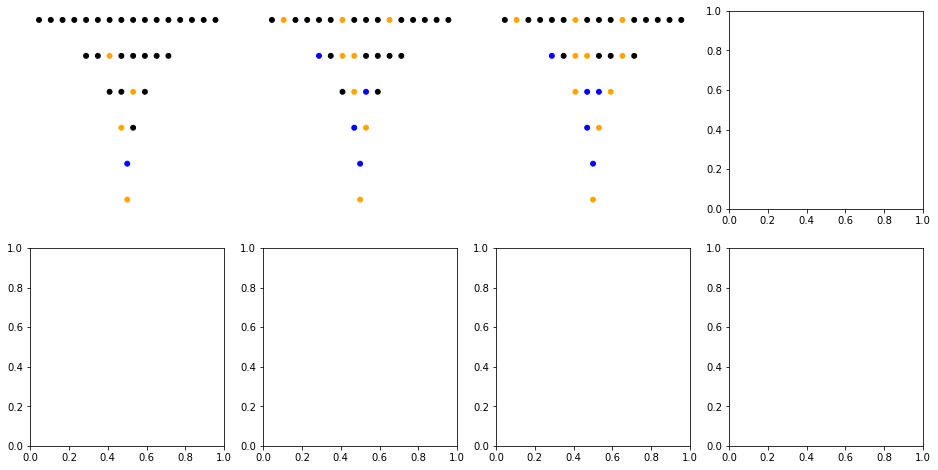

In [9]:
def save_subplot(tree, ax_idx):
    global n, dotsize
    x, y, colors = tree.getGeom()
    plt.axis('off')
    plt.scatter(x, y, s=dotsize, c=colors)
    fig = plt.gcf()

    fig.set_size_inches(3, 2)# -> n=6
    #fig.set_size_inches(16, 8)# -> n=9
    #fig.set_size_inches(46, 10)# -> n=12
    fig.savefig('{0}_{1}.png'.format(n, ax_idx), format='png', dpi=300)
    plt.close(fig)

def add_subplot(ax, tree, ax_idx):
    global dotsize
    x, y, colors = tree.getGeom()
    ax[ax_idx].axis('off')
    ax[ax_idx].scatter(x, y, s=dotsize, c=colors)

# dotsize=24 (n<=6)
# dotsize= 6 (n=9)
# dotsize= 1 (n>9)
n = 6
dotsize = 24

tree = Tree(n)
tree.mark(1)
tree.mark(3)
tree.mark(5)

subplot_size = 4
subplot_cols = 4
subplot_rows = n//subplot_cols + 1
fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(subplot_size*subplot_cols, subplot_size*subplot_rows))
ax = ax.flatten()

ax_idx = 0
iter = 0
while tree.checkTreeFrozen() == False and iter < 2**n:   
    for i in range(3, 2**n, 2):
        node = tree.getNode(i)
        if node.state == NodeState.ORANGE:
            new_marked_row = -1
            if Node.getType(i) == 2:
                # RULE 1 : if x is orange V(x) becomes orange 
                tree.mark(V(i))
                # RULE 2 : if x is orange S(x) becomes orange
                r2 = ruleTwo(i)
                if r2:
                    tree.mark(S(i))

            if Node.getType(i) == 3:
                # RULE 1 : if x is orange V(x) becomes orange 
                tree.mark(V(i))                
                # RULE 2 : if x is orange S(x) becomes orange
                r2 = ruleTwo(i)
                if r2:
                    tree.mark(S(i))
                # RULE 3 : if x is orange and of type C then (4x/3)-1 becomes orange
                tree.mark(int((4*i-1)/3))

            if Node.getType(i) == 1:
                # RULE 1 : if x is orange V(x) becomes orange 
                tree.mark(V(i))
                # RULE 2 : if x is orange S(x) becomes orange
                r2 = ruleTwo(i)
                if r2:
                    tree.mark(S(i))
                # RULE 4 : if x is orange and of type A then G(x)/3 becomes orange
                tree.mark(int(fG(i)/3))
                                
                new_marked_row = tree.checkRowMarked()
                if new_marked_row > 0:
                    add_subplot(ax, tree, ax_idx)
                    #save_subplot(tree, ax_idx)
                    ax_idx += 1

                if node.state == NodeState.ORANGE:
                    node.state = NodeState.BLUE
                break
            
            new_marked_row = tree.checkRowMarked()
            if new_marked_row > 0:
                add_subplot(ax, tree, ax_idx)
                #save_subplot(tree, ax_idx)
                ax_idx += 1
            
            if node.state == NodeState.ORANGE:
                node.state = NodeState.BLUE
    iter += 1

plt.show()